In [3]:
from matching.games import HospitalResident
import numpy.random as rng
import random
import numpy as np
import matplotlib.pyplot as plt
import dc_stat_think as dcst
import pandas as pd
from tqdm import tqdm
import matchingmarkets as mm
import matchingmarkets.algorithms as al
import copy
from copy import deepcopy
import networkx as nx

c:\users\gabriel abilleira\src\matchingmarkeets\matchingmarkets\algorithms\pulp\solvers.py:69: DeprecationWarning: The SafeConfigParser class has been renamed to ConfigParser in Python 3.2. This alias will be removed in future versions. Use ConfigParser directly instead.
  config = configparser.SafeConfigParser({'here':here,
c:\users\gabriel abilleira\src\matchingmarkeets\matchingmarkets\algorithms\pulp\pulp.py:103: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [4]:
class estudiante():
    def __init__(this,nombre,preferencias):
        this.nombre = nombre
        this.preferencias = preferencias

In [5]:
class universidad():
    def __init__(this,nombre,preferencias,capacidad):
        this.nombre = nombre
        this.preferencias = preferencias
        this.capacidad = capacidad
        
    def reduceCapacidad(this):
        if this.capacidad > 0:
            this.capacidad-=1
            return this.capacidad
        else:
            return this.capacidad

In [6]:
def boston(p_e,p_u,plazas,verbose):
    est = [estudiante(k,v) for k,v in p_e.items()]
    univs = [universidad(k,v,plazas[k]) for k,v in p_u.items()]
    est_copia_p = list(est)
    
    est_ord = []
    for i in range(len(est_copia_p)):
        estu = random.choice(est_copia_p)
        est_ord.append(estu)
        est_copia_p.pop(est_copia_p.index(estu))
    if verbose:
        print('Estudiantes ordenados : {}'.format([i.nombre for i in est_ord]))
    uni_copia = list(univs)
    est_copia = list(est_ord)
    matches = {}
    unmatched = []
    for i in range(len(univs)):
        uni_pot = {}
        if len(est_copia) != 0 and len(uni_copia) != 0:
            if verbose:
                print('Ronda: ' + str(i))
                print('Quedan por hacer match: {}'.format([i.nombre for i in est_copia]))
                print('Ya fueron asignados: {}'.format(list(matches.values())))
                print('No tienen pareja: {}'.format(unmatched))
                print('Quedan estas universidades: {}'.format([i.nombre for i in uni_copia]))
                if i > 0:
                    try:
                        print('Quedan estas capacidades: {}'.format([i.capacidad - len(matches[i.nombre]) for i in uni_copia]))
                    except KeyError as e:
                        print('Quedan estas capacidades: {}'.format([i.capacidad for i in uni_copia]))
                else:
                    print('Quedan estas capacidades: {}'.format([i.capacidad for i in uni_copia]))
            for j in est_copia:
                matched = False
                n = i
                #Solamente señalan a uno
                while matched == False:
                    try:
                        uni_pref = [u for u in univs if u.nombre == j.preferencias[n]][0]
                        if verbose:
                            print('Estudiante: ' + j.nombre,'Universidad a la que se presenta: ' + uni_pref.nombre, 'Universidades disponibles: {}'.format([i.nombre for i in uni_copia]))
                        if uni_pref in uni_copia:
                            if uni_pref not in uni_pot.keys():
                                uni_pot[uni_pref] = [j]
                            else:
                                uni_pot[uni_pref].append(j)
                            matched = True
                        else:
                            n+=1
                    except IndexError as e:
                        unmatched.append(j)
                        est_copia.remove(j)
                        matched = True
            if verbose:
                for key,value in uni_pot.items():
                    print('Universidad: ' + key.nombre, 'Posibles parejas : {}'.format([i.nombre for i in value]))
            for uni in uni_pot.keys():
                pot = uni_pot[uni]
                if uni.nombre not in matches.keys():
                    matches[uni.nombre] = []
                if len(pot) <= uni.capacidad - len(matches[uni.nombre]):
                        matches[uni.nombre].extend([i.nombre for i in uni_pot[uni]])
                        if verbose:
                            print('Universidad: ' + uni.nombre, 'Pareja: {}'.format(matches[uni.nombre]))
                        for i in matches[uni.nombre]:
                            if i in [i.nombre for i in est_copia]:
                                est_copia.pop(est_copia.index([j for j in est_copia if j.nombre == i][0]))
                else:
                        ind_actual = uni.preferencias.index(pot[-1].nombre)
                        while len(matches[uni.nombre]) != uni.capacidad:
                            for i in pot:
                                ind = uni.preferencias.index(i.nombre)
                                if ind < ind_actual:
                                    ind_actual = ind
                            matches[uni.nombre].append(uni.preferencias[ind_actual])
                            est_copia.pop(est_copia.index([i for i in est_copia if i.nombre == uni.preferencias[ind_actual]][0]))
                            pot.pop(pot.index([i for i in pot if i.nombre == uni.preferencias[ind_actual]][0]))
                            try:
                                ind_actual = uni.preferencias.index(pot[-1].nombre)
                            except IndexError as e:
                                pass
                            if verbose:
                                print('Universidad: ' + uni.nombre, 'Pareja: {}'.format(matches[uni.nombre]))
                if verbose:
                    print('Número de estudiantes en la plaza: ' + str(len(matches[uni.nombre])),'Número de plazas: ' + str(uni.capacidad))
                if len(matches[uni.nombre]) == uni.capacidad:
                    if verbose:
                        print('Eliminada')
                    uni_copia.pop(uni_copia.index(uni))
        else:
            unmatched.extend([i.nombre for i in est_copia])
            break
    if verbose:
        print(matches)
        print(unmatched)
    return matches,unmatched

In [7]:
class Agent:
    """
    A single agent in a matching market
    Attributes
    ---------
    discount_rate: float in [0,1]
        Rate of utility discounting
        between entry and match
    is_critical: bool
        1 when agent is critical
        automatically based on sojourn==time_to_critical
    name: int
        used to index agent in others' containers
    myType: object (typically in, sting or list<string>)
        agent's type. Used in matching to compute compatibility
    matchUtil: dict<name, int>
        utility from match with agent "name"
        UtilFct becomes matchUtil[name] * UtilFct
    matchFailProb: dict<name, [0,1]>
        fail probability (at each subsequent period)
        from matching with name
    sojourn: int
        # of periods agent is in market
    time_to_critical: int
        # of rounds from entry to criticality
        Generated by a Poisson process __at instantiation__
    UtilFct: fct(int) -> float
        may be overriden from default
    """
    def __init__(self, name=0, discount_rate=0, time_to_critical=0,
                 myType=1, myType2=None,cap=1,nota_media = 0,lang = [],lang_req = ''
                 ):
        """
        Default constructor is for 1 period market, homogeneous agents
        """
        self.name = name
        self.discount_rate = discount_rate
        self.time_to_critical = time_to_critical
        self.type = myType
        self.type2 = myType2
        self.match_util = dict()
        self.match_fail_prob = dict()
        self.sojourn = -1
        self.is_critical = 0
        self.cap = cap
        self.lang = lang
        self.lang_req = lang_req

    def addNewToMap(self, otherAgent, failProbResult=1,
                    utilityResult=1):
        """
        Adds new agents to self's preference maps
        Arguments
        ---------
        utilityResult: int
            Result of matchUtilFct
        failProbResult: float in [0,1]
            Result of compatFct
        """
        self.match_util[otherAgent.name] = utilityResult
        self.match_fail_prob[otherAgent.name] = failProbResult

    def update(self):
        """
        Called when time advances
        Updates members
        """
        self.sojourn += 1
        if self.sojourn >= self.time_to_critical:
            self.is_critical = 1

    def expUtilFct(self, t):
        """
        exponential utility discounting
        """
        return np.exp(- (1-self.discount_rate) * t)

    def linearUtilFct(self, t):
        """
        Linear time discounting
        """
        if t == 0:
            return 1
        return self.discount_rate ** t

    def utilFct(self, t=None, fct=linearUtilFct, matchUtility=1):
        """
        Used to pass arbitrary utilityFct
        """
        if t is None:
            t = self.sojourn
        return matchUtility * fct(self, t)

    def neighbors(self, with_self=False):
        """
        returns list<mm.Agent.name>
        where match_fail_prob > 0
        """
        neighbors = [
            key for key in self.match_fail_prob.keys()
            if self.match_fail_prob[key] > 0
            ]
        return neighbors

In [8]:
# Matching algorithms should take a list of agents
# then return a dict of directed matches
# Bilateral matches should have both pointing to each other
# The concept of __initiation__ of a match is important
# input agents can initiate match attempts with all agents in market
#      Arguments
#    ---------
#    Agents: list
#        list of agents initiating matches
#    Returns
#    -------
#    dict { agent.name : agent.name } of matches


def strongly_connected_components(graph):
    """
    Find the strongly connected components in a graph using
    Tarjan's algorithm.
    Implementation credit: http://www.logarithmic.net/pfh/blog/01208083168
    Used to find cycles in TTC algorithm
    Arguments
    --------
    graph: dict< node_name, list<node_name> >
         mapping node names to lists of successor nodes.
    Returns
    -------
    list of tuples of SCCs in graph
    """

    index_counter = [0]
    stack = []
    lowlinks = {}
    index = {}
    result = []

    def strongconnect(node):
        # set the depth index for this node to the smallest unused index
        index[node] = index_counter[0]
        lowlinks[node] = index_counter[0]
        index_counter[0] += 1
        stack.append(node)

        # Consider successors of `node`
        try:
            successors = graph[node]
        except:
            successors = []
        for successor in successors:
            if successor not in lowlinks:
                # Successor has not yet been visited; recurse on it
                strongconnect(successor)
                lowlinks[node] = min(lowlinks[node], lowlinks[successor])
            elif successor in stack:
                # the successor is in the stack
                # hence in the current strongly connected component (SCC)
                lowlinks[node] = min(lowlinks[node], index[successor])

        # If `node` is a root node, pop the stack and generate an SCC
        if lowlinks[node] == index[node]:
            connected_component = []

            while True:
                successor = stack.pop()
                connected_component.append(successor)
                if successor == node:
                    break
            component = tuple(connected_component)
            # storing the result
            result.append(component)

    for node in graph:
        if node not in lowlinks:
            strongconnect(node)

    return result


def TTC(Mrkt, Agents, verbose=False):
    """
    Top Trading Cycle algorithm
    Agents initiating cycles
    Preferences are weighed by expected utility
    That is, utility of 10 with 50% success rate
    is weighed as 5 utils by agent in ranking
    NOTE: Algorithm not guaranteed to be deterministic
          if preferences are not strict
    """
    matched = dict()
    to_match = list(Agents)
    iter_num = 0
    # While agents unmatched, iterate
    while len(to_match) > 0:
        iter_num += 1
        to_match_names = [a.name for a in to_match]

        if verbose:
            print("\n\n-------------------\nTTC Iteration ",
                  iter_num, "\n\tTo Match", to_match_names)

        preference_graph = dict()

        # If no neighbors, remove
        for agent in reversed(to_match):
            if len(set(agent.neighbors()).intersection(to_match_names)) == 0:
                to_match.remove(agent)
                to_match_names.remove(agent.name)
                if verbose:
                    print("\tremoved agent ", agent.name)
        # Now, get preferences and form graph
        for agent in to_match:
            # Sort preferences in decreasing order
            preferenceList = sorted(agent.match_util,
                                    key=lambda k: agent.match_util[k] *
                                    agent.match_fail_prob[k],
                                    reverse=True)
            
            # Add top available preference to graph
            for preference in preferenceList:
                if preference in to_match_names:
                    preference_graph[agent.name] = [preference]
                    break

        if verbose:
            print("\n\nPreference Graph\n\t", preference_graph)

        # Find cycles in graph
        cycles = strongly_connected_components(preference_graph)

        if verbose:
            print("\n\nCycles\n\t", cycles)

        for cycle in cycles:
            # if cycle singleton, add to match if pointing to self
            if len(cycle) == 1:
                if preference_graph[cycle[0]] == [cycle[0]]:
                    matched[cycle[0]] = cycle[0]
                    to_remove_index = np.inf
                    for i in range(len(to_match)):
                        if to_match[i].name == cycle[0]:
                            to_remove_index = i
                            del to_match[to_remove_index]
                            break
                continue
            # else add members of cycle to result and clean to_match up
            for i in range(len(cycle)):
                if cycle[i-1][0] == 'E' and  preference_graph[cycle[i-1]][0] == cycle[i]:
                    matched[cycle[i-1]] = cycle[i]
                elif cycle[i][0] == 'E' and  preference_graph[cycle[i]][0] == cycle[i-1]:
                    matched[cycle[i]] = cycle[i-1]
                
            for i in range(len(cycle)):
                for agent in to_match:
                    if agent.name == cycle[i]:
                        if agent.name[0] == 'E':
                            if matched[agent.name][0] == 'U':
                                uni = [i for i in to_match if i.name == matched[agent.name]][0]
                                uni.cap = uni.cap - 1
                                if uni.cap <= 0:
                                    to_match.remove(uni)
                                to_match.remove(agent)
                            else:
                                to_match.remove(agent)
                        else:
                            pass
    
    matching = {}
    for k,v in matched.items():
        if v not in matching.keys():
            matching[v] = [k]
        else:
            matching[v].append(k)
    return matching

In [9]:
def simul_m(estudiantes,unis,d1_s,d1_u,cap,verbose):    
    pl = 0
    
    if verbose:
        print(d1_s,'\n',d1_u,'\n',cap)
    #Corremos el juego
    match = boston(d1_s,d1_u,cap,verbose)
    
    #Análisis
    parejas = []
    for i in match[0].values():
        for j in i:
            parejas.append(j)
    sin_pareja = match[1]
    
    def utilidad(i):
        uni = [k for k,v in match[0].items() if i in [j for j in v]][0]
        pref = d1_s[i]
        num = pref.index(uni) + 1
        return num 
    
    utilidades = {}
    for i in sin_pareja:
        utilidades[i] = 0
    for i in parejas:
        utilidades[i] = utilidad(i)
    
    return len(sin_pareja),utilidades, pl

In [10]:
def simul_ttc(est,univs,estudiantes,unis,d1_s,d1_u,verbose):
    
    pl = 0
    
    #Creamos el mercado
    markt = mm.Market()
    markt.Agents.extend(est)
    markt.Agents.extend(univs)

    if verbose:
        print([i.match_util for i in markt.Agents])
        print([i.name for i in markt.Agents if i.name[0] == 'U'],[i.cap for i in markt.Agents if i.name[0] == 'U'])

    #Corremos el juego
    matching = TTC(markt,markt.Agents,verbose)
    if verbose:
        print(matching)
    
    def utilidad(i):
        uni = [k for k,v in matching.items() if i in [j for j in v]][0]
        pref = d1_s[i]
        num = pref.index(uni) + 1
        return num 
    
    pareja = []
    for k,v in matching.items():
        if k != v[0]:
            for j in v:
                if j in estudiantes:
                    pareja.append(j)
    no_asignados = []
    for i in estudiantes:
        if i not in pareja:
            no_asignados.append(i)
            
    utilidades = {}
    for i in no_asignados:
        utilidades[i] = 0
    for i in pareja:
        utilidades[i] = utilidad(i)
    
    return len(no_asignados),utilidades, pl #Suma de los valores en los dos

In [11]:
def simul(estudiantes,unis,d1_s,d1_u,cap):
    
    pl = 0
    
    #Corremos el juego:
    game = HospitalResident.create_from_dictionaries(d1_s,d1_u,cap)
    matching = game.solve(optimal = 'resident')
    assert game.check_validity()
    assert game.check_stability()
    
    def utilidad(i):
        uni = [k.name for k,v in matching.items() if i in [j.name for j in v]][0]
        pref = d1_s[i]
        num = pref.index(uni) + 1
        return num 
    
    pareja = []
    for i in matching.values():
        for j in i:
            if j.name in estudiantes:
                pareja.append(j.name)
    no_asignados = []
    for i in estudiantes:
        if i not in pareja:
            no_asignados.append(i)
    
    utilidades = {}
    for i in no_asignados:
        utilidades[i] = 0
    for i in pareja:
        utilidades[i] = utilidad(i)
    
    return len(no_asignados),utilidades, pl #Suma de los valores en los dos

In [12]:
def preferencias(n_e,n_u,max_plaza):
    
    plazas_libres = []
    alumnos_sin = []
    sacar = []
    
    #Creamos los agentes
    est = [Agent() for i in range(n_e)]
    univs = [Agent() for i in range(n_u)]
    
    #Idiomas
    prob_idioma = [0,0,0,0,0,1,1,1,2,2] #Inglés,Francés,Alemán
    prob_nivel_eng = [0,1,1,2,2,2,2,3,3,3,3,3,3,4,4,4,4,4,5,5] #A1,A2,B1,B2,C1,C2
    prob_nivel_fra = [0,0,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,4,4,5] #A1,A2,B1,B2,C1,C2
    prob_nivel_ale = [0,0,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,4,4,5] #A1,A2,B1,B2,C1,C2
    #Requisitos
    prob_idioma_u = [0,0,0,0,0,1,1,1,2,2] #Inglés,Francés,Alemán
    prob_nivel_eng_u = [0,1,1,2,2,2,2,3,3,3,3,3,3,4,4,4,4,4,5,5] #A1,A2,B1,B2,C1,C2
    prob_nivel_fra_u = [0,0,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,4,4,5] #A1,A2,B1,B2,C1,C2
    prob_nivel_ale_u = [0,0,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,4,4,5] #A1,A2,B1,B2,C1,C2
    #Claves
    dict_idioma = {0:'I',1:'F',2:'A'}
    dict_nivel = {0:'A1',1:'A2',2:'B1',3:'B2',4:'C1',5:'C2'}
    
    for i in range(len(est)):
        est[i].name = 'E'+str(i+1)
        est[i].nota_media = round(random.uniform(5,10),2)
        ele = dict_idioma[np.random.choice(prob_idioma)]
        if ele == 'I':
            est[i].lang = [ele + '-' + dict_nivel[np.random.choice(prob_nivel_eng)]]
        elif ele == 'F':
            est[i].lang = [ele + '-' + dict_nivel[np.random.choice(prob_nivel_fra)]]
        elif ele == 'A':
            est[i].lang = [ele + '-' + dict_nivel[np.random.choice(prob_nivel_ale)]]
        else:
            raise ValueError('ERROR')
        mas  = np.random.randint(0,100)
        if mas <= 5:
            while ele in est[i].lang[0]:
                ele = dict_idioma[np.random.choice(prob_idioma)]
            if ele == 'I':
                est[i].lang.append(ele + '-' + dict_nivel[np.random.choice(prob_nivel_eng)])
            elif ele == 'F':
                est[i].lang.append(ele + '-' + dict_nivel[np.random.choice(prob_nivel_fra)])
            elif ele == 'A':
                est[i].lang.append(ele + '-' + dict_nivel[np.random.choice(prob_nivel_ale)])
            else:
                raise ValueError('ERROR')    
    for i in range(len(univs)):
        univs[i].name = 'U'+str(i+1)
        ele = dict_idioma[np.random.choice(prob_idioma_u)]
        if ele == 'I':
            univs[i].lang_req = ele + '-' + dict_nivel[np.random.choice(prob_nivel_eng_u)]
        elif ele == 'F':
            univs[i].lang_req = ele + '-' + dict_nivel[np.random.choice(prob_nivel_fra_u)]
        elif ele == 'A':
            univs[i].lang_req = ele + '-' + dict_nivel[np.random.choice(prob_nivel_ale_u)]
        else:
            raise ValueError('ERROR')
            
    
    d1_u = {}
    for i in univs:
        d1_u[i.name] = []
    
    cap = {i:rng.randint(1,(max_plaza+1)) for i in d1_u.keys()}
    
    for i in univs:
        for j in cap.keys():
            if i.name == j:
                i.cap = cap[j]
    
    for i in est:
        posibles = []
        for uni in univs:
            for l in i.lang:
                if uni.lang_req[0] in l and uni.lang_req[2:] <= l[2:]:
                    if uni not in posibles:
                        posibles.append(uni)
        if len(posibles) != 0:
            match = False
            n = len(posibles)
            while match == False:
                z = random.choice(posibles)
                if z.name not in i.match_util.keys():
                    i.addNewToMap(z,utilityResult = n)
                    n -= 1
                if len(posibles) == len(i.match_util) or len(i.match_util) == 8:
                    match = True
            i.addNewToMap(i,utilityResult = 0)
            for j in est:
                if j != i:
                    i.addNewToMap(j,utilityResult = -1000)
            for j in univs:
                if j.name not in i.match_util.keys():
                    i.addNewToMap(j,utilityResult = -1000)
        else:
            alumnos_sin.append(i)
    for i in alumnos_sin:
        est.remove(i)
    
    for i in univs:
        contador = 0
        factor = np.random.uniform(0,1)
        for e in est:
            if e.match_util[i.name] > 0:
                contador+=1
        if contador != 0:
            match = False
            while match == False:
                z = random.choice(est)
                if z.name not in i.match_util.keys():
                    if i.name in z.match_util.keys() and z.match_util[i.name] > 0:
                        i.addNewToMap(z,utilityResult = z.nota_media + factor)
                    else:
                        i.addNewToMap(z,utilityResult = -1000)
                if len(i.match_util) == len(est):
                    match = True
            i.addNewToMap(i,utilityResult = 0)
            for j in univs:
                if j != i:
                    i.addNewToMap(j,utilityResult = -1000)
        else:
            sacar.append(i)
            for n in range(i.cap):
                plazas_libres.append(i)
    for i in sacar:
        univs.remove(i)
    
    for uni in univs:
        contador = 0
        for e in est:
            if e.match_util[uni.name] > 0:
                contador+=1
        if contador != uni.cap:
            for i in range(uni.cap - contador):
                plazas_libres.append(uni)
    #Lo otro
    d1_s = {}
    estudiantes = [i.name for i in est]
    universidades = [i.name for i in univs]
    for i in est:
        d1_s[i.name] = []
        for j in i.match_util.keys():
            if j in universidades and i.match_util[j] > 0:
                d1_s[i.name].append(j)
                
    d1_u = {}
    for i in univs:
        d1_u[i.name] = []
    for i in univs:
        mal = []
        for j in i.match_util.keys():
            if j in estudiantes:
                if i.match_util[j] > 0:
                    d1_u[i.name].append(j)
                else:
                    mal.append(j)
    total = 0
    for i in cap.values():
        total+=i
            
    return est,univs,estudiantes,universidades,d1_s,d1_u,cap,len(alumnos_sin),round(len(plazas_libres)/total,2)

In [13]:
info = preferencias(150,20,10)

In [16]:
n = 1000
ne = 300
nu = 40
max_plaza = 10
no_asignados_gs = np.zeros(n)
pl_gs = np.zeros(n)
utilidades_gs = []
no_asignados_b = np.zeros(n)
utilidades_b = []
pl_b = np.zeros(n)
no_asignados_ttc = np.zeros(n)
utilidades_ttc = []
pl_ttc = np.zeros(n)
alumnos_fuera = np.zeros(n)
plazas_desperdiciadas = np.zeros(n)
for i in tqdm(range(n)):
    info = preferencias(ne,nu,max_plaza)
    resultados_gs = simul(info[2],info[3],info[4],info[5],info[6])
    no_asignados_gs[i] = resultados_gs[0]
    utilidades_gs.append(resultados_gs[1])
    pl_gs[i] = resultados_gs[2]
    resultados_b = simul_m(info[2],info[3],info[4],info[5],info[6],False)
    no_asignados_b[i] = resultados_b[0]
    utilidades_b.append(resultados_b[1])
    pl_b[i] = resultados_b[2]
    resultados_ttc = simul_ttc(info[0],info[1],info[2],info[3],info[4],info[5],False)
    no_asignados_ttc[i] = resultados_b[0]
    utilidades_ttc.append(resultados_b[1])
    pl_ttc[i] = resultados_ttc[2]
    alumnos_fuera[i] = info[7]
    plazas_desperdiciadas[i] = info[8]

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [2:22:16<00:00,  8.54s/it]


In [17]:
resultados_gs = {}
for i in utilidades_gs:
    for j in i.values():
        if j not in resultados_gs.keys():
            resultados_gs[j] = 1
        else:
            resultados_gs[j]+=1

resultados_b = {}
for i in utilidades_b:
    for j in i.values():
        if j not in resultados_b.keys():
            resultados_b[j] = 1
        else:
            resultados_b[j]+=1
            
resultados_ttc = {}
for i in utilidades_ttc:
    for j in i.values():
        if j not in resultados_ttc.keys():
            resultados_ttc[j] = 1
        else:
            resultados_ttc[j]+=1
#plazas_sin = pd.Series(plazas_desperdiciadas).value_counts().sort_values(ascending = False)
plazas_sin = np.mean(plazas_desperdiciadas)
alumnos_sin = np.median(alumnos_fuera)

In [18]:
resultados_gs_norm = list(map(lambda x: round((x/sum(resultados_gs.values()))*100,2), resultados_gs.values()))
resultados_b_norm = list(map(lambda x: round((x/sum(resultados_b.values()))*100,2), resultados_b.values()))
resultados_ttc_norm = list(map(lambda x: round((x/sum(resultados_ttc.values()))*100,2), resultados_ttc.values()))
print('Los primeros son sin asignar, de ahí, primera posición en adelante: (en %)')
print('Usando DA: {}'.format(resultados_gs_norm),'\nUsando Boston: {}'.format(resultados_b_norm),'\nUsando TTC: {}'.format(resultados_ttc_norm))
print('Plazas sin asignar: ')
print('Promedio de plazas sin cubrir: \n{}'.format(plazas_sin),'\nPromedio de alumnos sin plaza: {}'.format(alumnos_sin))

Los primeros son sin asignar, de ahí, primera posición en adelante: (en %)
Usando DA: [33.77, 4.17, 19.59, 5.68, 10.13, 14.0, 7.66, 2.95, 2.05] 
Usando Boston: [36.46, 51.2, 2.04, 0.69, 1.23, 2.66, 3.22, 1.61, 0.87] 
Usando TTC: [36.46, 51.2, 2.04, 0.69, 1.23, 2.66, 3.22, 1.61, 0.87]
Plazas sin asignar: 
Promedio de plazas sin cubrir: 
0.03196 
Promedio de alumnos sin plaza: 0.0


In [19]:
codigos = []
opciones_gs = {}
opciones_b = {}
opciones_ttc = {}
for i in range(len(resultados_gs_norm)):
    if i == 0:
        codigos.append('Sin asignar')
    else:
        codigos.append(str(i)+'ª opción')
for i in range(len(resultados_gs_norm)):
    opciones_gs[codigos[i]] = resultados_gs_norm[i]
    opciones_b[codigos[i]] = resultados_b_norm[i]
    opciones_ttc[codigos[i]] = resultados_ttc_norm[i]

df_gs = pd.DataFrame({'Opción':codigos,'Porcentaje':resultados_gs_norm})
df_gs.set_index('Opción', inplace = True)
df_b = pd.DataFrame({'Opción':codigos,'Porcentaje':resultados_b_norm})
df_b.set_index('Opción', inplace = True)
df_ttc = pd.DataFrame({'Opción':codigos,'Porcentaje':resultados_ttc_norm})
df_ttc.set_index('Opción', inplace = True)

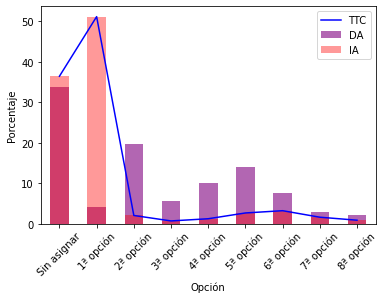

In [20]:
%matplotlib inline
ax = df_gs.plot(kind = 'bar',color = 'purple', label = 'DA', legend = False, alpha = 0.6)
df_b.plot(kind = 'bar',ax = ax,color = 'red', label = 'IA', legend = False, alpha = 0.4)
df_ttc.plot(ax = ax, color = 'blue', label = 'TTC', legend = False)
_ = ax.legend(['TTC','DA','IA'])
_ = plt.xlabel('Opción')
_ = plt.ylabel('Porcentaje')
_ = plt.xticks(rotation = 45)